In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.options.mode.chained_assignment = None

In [2]:
# Specify the path to your data in Google Drive or locally
filePath = "../data/complete_COVID_SAMPLES.tsv" 

df = pd.read_table(filePath, low_memory=False, engine="c")

optional_fields = ['hospitalized']

In [3]:
# Select the columns that are listed above
df = df[['sample', 'templates', 'amino_acid', 'rearrangement', 'v_resolved', 'd_resolved','j_resolved','hospitalized']]

# Rename the columns 
df.columns = ['sample', '#count' , 'cdr3aa' , 'cdr3nt' , 'v' , 'd' , 'j' , 'hospitalized']

# Remove "_TCRB" part from the sample name
df['sample'] = df['sample'].map(lambda x: x.rstrip('_TCRB'))

# Create a dataframe with reads count for each sample
df_reads = df.groupby(['sample', 'hospitalized']).agg({'#count': 'sum'}).reset_index().rename(columns={'#count': "count"})

# Calculate clonotype frequency
df = pd.merge(df, df_reads, how='outer', on=['sample','hospitalized']).fillna(0)
df['freq'] = df['#count'] / (df['count'] * 1.0)
df.fillna(0, inplace=True)

# Create a dataframe with clonotype count for each sample
df_diversity = df.groupby(['sample', 'hospitalized'], sort=False).size().reset_index(name='clonotype_count')

# Add clonotype count of each sample as a column to create a new dataframe
df = pd.merge(df, df_diversity, on=['sample', 'hospitalized'])

df

,sample,#count,cdr3aa,cdr3nt,v,d,j,hospitalized,count,freq,clonotype_count
0,6232BW,3636,CASSLGLAGPGFF,ACGATCCAGCGCACAGAGCAGGAGGACTCGGCCGTGTATCTCTGTG...,TCRBV07-02,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.008268,218977
1,6232BW,3037,CASRVGSSYNEQFF,ATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCA...,TCRBV12,TCRBD02-01*02,TCRBJ02-01*01,True,439782,0.006906,218977
2,6232BW,2293,CASNPYRVNTGELFF,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,TCRBV27-01*01,TCRBD02-01*02,TCRBJ02-02*01,True,439782,0.005214,218977
3,6232BW,1960,CASSALRSSYNEQFF,CAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTGCCAGCT...,TCRBV12,unknown,TCRBJ02-01*01,True,439782,0.004457,218977
4,6232BW,1896,CASSFEDEGGETQYF,AACGCCTTGTTGCTGGGGGACTCGGCCCTCTATCTCTGTGCCAGCA...,TCRBV05-06*01,unknown,TCRBJ02-05*01,True,439782,0.004311,218977
...,...,...,...,...,...,...,...,...,...,...,...
15061643,1566265BW,1,CSVEDLRGGYTF,CTGACTGTGAGCAACATGAGCCCTGAAGACAGCAGCATATATCTCT...,TCRBV29-01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061644,1566265BW,1,CASGRRGDYGYTF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,unknown,TCRBJ01-02*01,False,758231,0.000001,453526
15061645,1566265BW,1,CASSWTGNSPLHF,AAGATCCAGCCCTCAGAACCCAGGGACTCAGCTGTGTACTTCTGTG...,TCRBV12-03/12-04*01,TCRBD02-01,TCRBJ01-06*02,False,758231,0.000001,453526
15061646,1566265BW,1,CASSLDWTEYYEQYF,CAGCCTGCAAAGCTTGAGGACTCGGCCGTGTATCTCTGTGCCAGCA...,TCRBV11-02*01,TCRBD01-01*01,TCRBJ02-07*01,False,758231,0.000001,453526


In [4]:
df['aa_length'] = df['cdr3aa'].str.len()

df_aa_spectratype = df.groupby(['sample', 'hospitalized', 'aa_length'], as_index=False)[
    'freq'].agg({'spectratype': 'sum'})

df_aa_max_spectratype = df_aa_spectratype.loc[df_aa_spectratype.groupby('sample')['spectratype'].idxmax()]

Amino acid motif count

In [5]:
# Define the function to count amino acid motifs (k is the length of the motif)
def aamotif(k, aa_list):
    aamotifCount = {}
    for aa in aa_list:
        for i in range(len(aa)-k+1):
            aamotif = aa[i:i+k]
            aamotifCount[aamotif] = aamotifCount.get(aamotif, 0)+1
    return aamotifCount

# Create an empty dataframe for storing results
df_aa_motif = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    # Use amino acid motif length of 6 as an example
    df_temp = aamotif(6, df_temp['cdr3aa'])
    df_temp = pd.DataFrame(df_temp.items(), columns=['motif', 'count'])
    df_temp['sample'] = sample

    # Append the dataframe based on amino acid motifs and stores in the result dataframe
    df_aa_motif = df_aa_motif.append(df_temp, ignore_index=True)

    # Add the hospitalization information as a column
    df_aa_motif_1 = df_aa_motif.merge(
        df_aa_max_spectratype[['sample', 'hospitalized']], on='sample')

df_aa_motif_1

,motif,count,sample,hospitalized
0,CASNPR,64,2402BW,False
1,ASNPRG,32,2402BW,False
2,SNPRGY,7,2402BW,False
3,NPRGYE,2,2402BW,False
4,PRGYEA,5,2402BW,False
...,...,...,...,...
38430039,VVGAAF,1,3977BW,False
38430040,SARSQR,1,3977BW,False
38430041,ARSQRV,1,3977BW,False
38430042,RSQRVG,1,3977BW,False


## FigureS7a

In [6]:
# Remove motif counts that are less than 9999
df_aa_motif_1 = df_aa_motif_1[df_aa_motif_1['count'] > 9999]

# Select the motifs that present in more than 2 samples
df_aa_motif_2 = df_aa_motif_1.groupby(['hospitalized','motif'], sort=False).size().reset_index(name='number_of_samples')
df_aa_motif_2 = df_aa_motif_2[df_aa_motif_2['number_of_samples'] > 2]
df_aa_motif_1 = pd.merge(df_aa_motif_1, df_aa_motif_2, on=['hospitalized','motif'])
df_aa_motif_1

,motif,count,sample,hospitalized,number_of_samples
0,NTEAFF,12990,2402BW,False,36
1,NTEAFF,21022,1566889BW,False,36
2,NTEAFF,15657,712387BW,False,36
3,NTEAFF,12810,1568100BW,False,36
4,NTEAFF,18045,1564208BW,False,36
...,...,...,...,...,...
345,SYNEQF,17392,1566486BW,False,3
346,SYNEQF,11000,1337122BW,False,3
347,NTGELF,10586,712387BW,False,3
348,NTGELF,11640,1566486BW,False,3


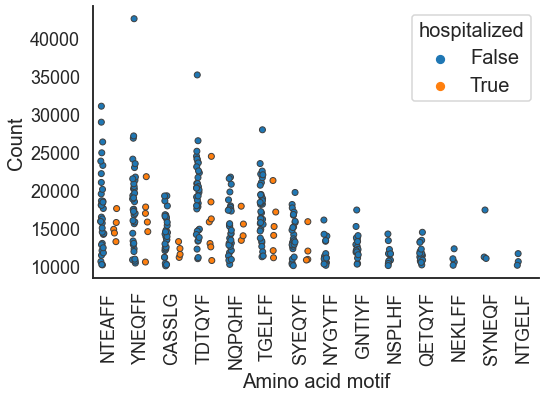

In [7]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(8,5))

ax = sns.stripplot(data=df_aa_motif_1, x='motif', y='count', hue=attribute, dodge=True, size=6, linewidth=1)

ax.set_xlabel('Amino acid motif', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='20')
sns.despine()

plt.savefig("../figures/supplementary/figureS7a.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS7a.png",bbox_inches="tight")

plt.show()

Nucleotide sequence motif count

In [8]:
# Define the function to count nucleotide motifs (k is the length of the motif)
def ntmotif(k, nt_list):
    ntmotifCount = {}
    for nt in nt_list:
        for i in range(len(nt)-k+1):
            ntmotif = nt[i:i+k]
            ntmotifCount[ntmotif] = ntmotifCount.get(ntmotif, 0)+1
    return ntmotifCount

# Create an empty dataframe for storing results
df_nt_motif = pd.DataFrame()

# Create a list of the sample names
samples = set(df['sample'])

for sample in samples:

    # Store the rows related to the sample
    df_temp = df.loc[df['sample'] == sample]

    # Use amino acid motif length of 6 as an example
    df_temp = ntmotif(6, df_temp['cdr3nt'])
    df_temp = pd.DataFrame(df_temp.items(), columns=['motif', 'count'])
    df_temp['sample'] = sample

    # Append the dataframe based on amino acid motifs and stores in the result dataframe
    df_nt_motif = df_nt_motif.append(df_temp, ignore_index=True)

    # Add the hospitalization information as a column
    df_nt_motif_1 = df_nt_motif.merge(
        df_aa_max_spectratype[['sample', 'hospitalized']], on='sample')

df_nt_motif_1

,motif,count,sample,hospitalized
0,NTGTCG,15579,2402BW,False
1,TGTCGG,16392,2402BW,False
2,GTCGGC,17431,2402BW,False
3,TCGGCT,19685,2402BW,False
4,CGGCTG,19439,2402BW,False
...,...,...,...,...
197985,NCGTCG,1,3977BW,False
197986,NNNAAG,1,3977BW,False
197987,NNAAGA,1,3977BW,False
197988,NAAGAG,1,3977BW,False


## FigureS7b

In [9]:
# Remove motif counts that are less than 150000
df_nt_motif_1 = df_nt_motif_1[df_nt_motif_1['count'] > 150000]

# Select the motifs that present in more than 2 samples
df_nt_motif_2 = df_nt_motif_1.groupby(['hospitalized','motif'], sort=False).size().reset_index(name='number_of_samples')
df_nt_motif_2 = df_nt_motif_2[df_nt_motif_2['number_of_samples'] > 2]
df_nt_motif_1 = pd.merge(df_nt_motif_1, df_nt_motif_2, on=['hospitalized','motif'])
df_nt_motif_1

,motif,count,sample,hospitalized,number_of_samples
0,TCTGTG,222675,2402BW,False,37
1,TCTGTG,328223,1566913BW,False,37
2,TCTGTG,335777,1566889BW,False,37
3,TCTGTG,358709,712387BW,False,37
4,TCTGTG,226874,1568100BW,False,37
...,...,...,...,...,...
595,CAGCTT,165107,1445BW,False,4
596,CAGCTT,166120,1337122BW,False,4
597,TTTTGG,154038,1566265BW,False,3
598,TTTTGG,184860,1566486BW,False,3


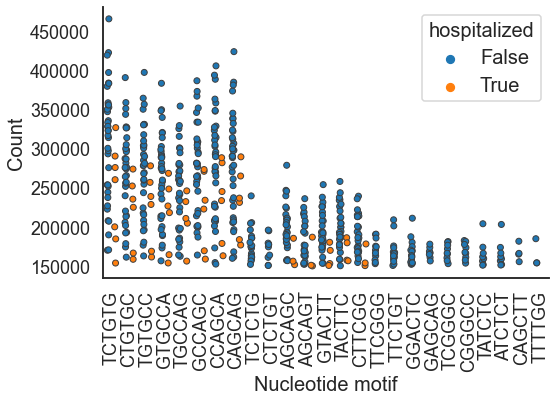

In [10]:
attribute = "hospitalized"

sns.set_style("white") 
sns.set_context("talk")

ax = plt.subplots(figsize=(8,5))

ax = sns.stripplot(data=df_nt_motif_1, x='motif', y='count', hue=attribute, dodge=True, size=6, linewidth=1)

ax.set_xlabel('Nucleotide motif', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(fontsize=18, rotation=90)
plt.yticks(fontsize=18)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.setp(ax.get_legend().get_title(), fontsize='20')
sns.despine()

plt.savefig("../figures/supplementary/figureS7b.pdf",bbox_inches="tight")
plt.savefig("../figures/supplementary/figureS7b.png",bbox_inches="tight")

plt.show()